In [1]:
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с файловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
import seaborn as sns
#sns.set_style('darkgrid')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height =  320 # Высота уменьшенной картинки 
directory = '/content/drive/My Drive/My Drive/Базы/Поражения/' # Указываем путь к обучающей выборке с оригинальными изображениями
num_classes = 2 # Количество классов на изображении

In [4]:
benign = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

s=0
cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'benign')): # Проходим по всем файлам в каталоге по указанному пути     
    s+=1
    #print(s)
    benign.append(image.load_img(os.path.join(directory + 'benign',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 20.51124882698059c


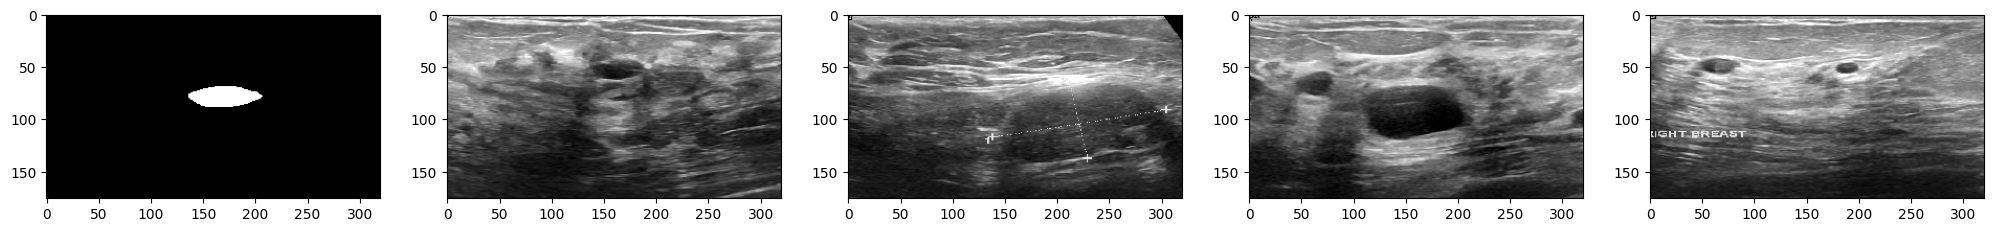

In [5]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(benign) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [6]:
images_origin = benign[::2]
images_segment = benign[1::2]

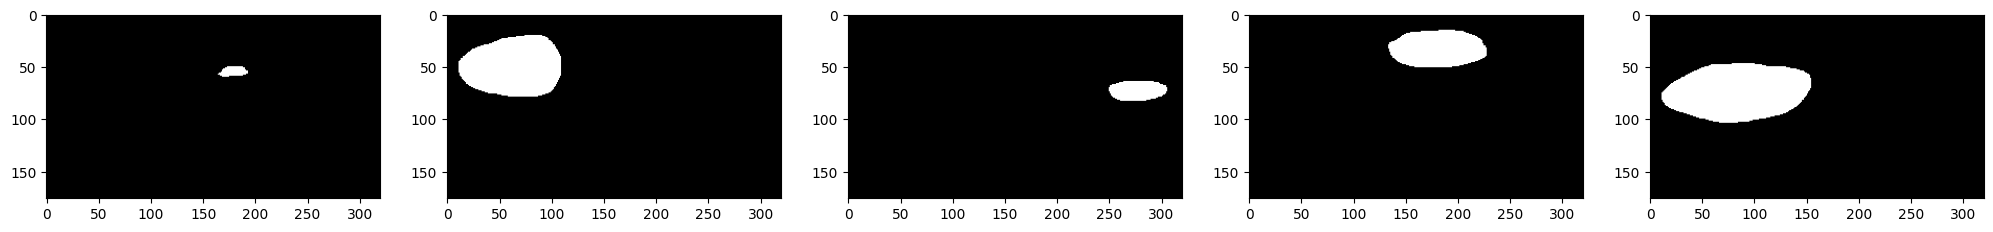

In [7]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = images_segment[i] # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [8]:
len(images_segment)

421

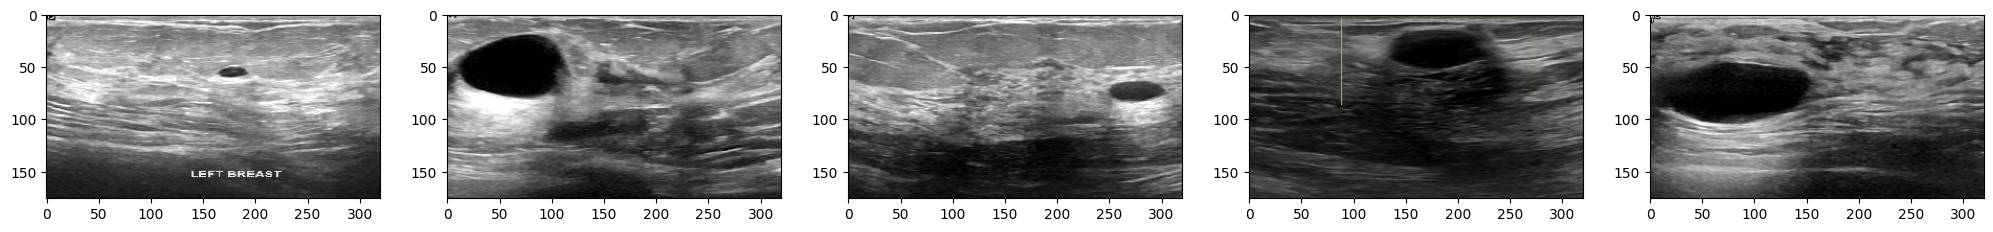

In [9]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = images_origin[i] # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [10]:
len(images_origin)

421

In [11]:
# Функция преобразования пикселя сегментированного изображения в индекс (6 классов)
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 20  : index = 1 # самолет    
    return index 

In [12]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем каналам изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходному размеру
  return yt # Возвращаем сформированный массив

In [13]:
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегментации
  for seg in data: # Пробегаем по всем файлам набора с сегментированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [14]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images_origin: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(421, 176, 320, 3)


In [15]:
cur_time = time.time()
yTrain = yt_prep(images_segment, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c')

100
200
300
400
Время обработки:  327.29 c


In [16]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [17]:
y_train.shape

(378, 176, 320, 2)

In [18]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

U-NET



In [19]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='mean_squared_error',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [20]:
model = unet(num_classes, (img_width, img_height,3))
history = model.fit(xTrain, yTrain, epochs=35, batch_size=16, validation_data = (x_val, y_val)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/35
27/27 [==============================] - 66s 1s/step - loss: 0.0633 - dice_coef: 0.8845 - val_loss: 0.9241 - val_dice_coef: 0.0768
Epoch 2/35
27/27 [==============================] - 18s 680ms/step - loss: 0.0471 - dice_coef: 0.9169 - val_loss: 0.9277 - val_dice_coef: 0.0726
Epoch 3/35
27/27 [==============================] - 19s 692ms/step - loss: 0.0424 - dice_coef: 0.9243 - val_loss: 0.7385 - val_dice_coef: 0.2417
Epoch 4/35
27/27 [==============================] - 19s 702ms/step - loss: 0.0423 - dice_coef: 0.9233 - val_loss: 0.7035 - val_dice_coef: 0.2519
Epoch 5/35
27/27 [==============================] - 19s 715ms/step - loss: 0.0419 - dice_coef: 0.9211 - val_loss: 0.9032 - val_dice_coef: 0.0900
Epoch 6/35
27/27 [==============================] - 19s 707ms/step - loss: 0.0431 - dice_coef: 0.9211 - val_loss: 0.6036 - val_dice_coef: 0.3525
Epoch 7/35
27/27 [==============================] - 19s 699ms/step - loss: 0.0370 - dice_coef: 0.9305 - val_loss: 0.2160 - val_dice_c

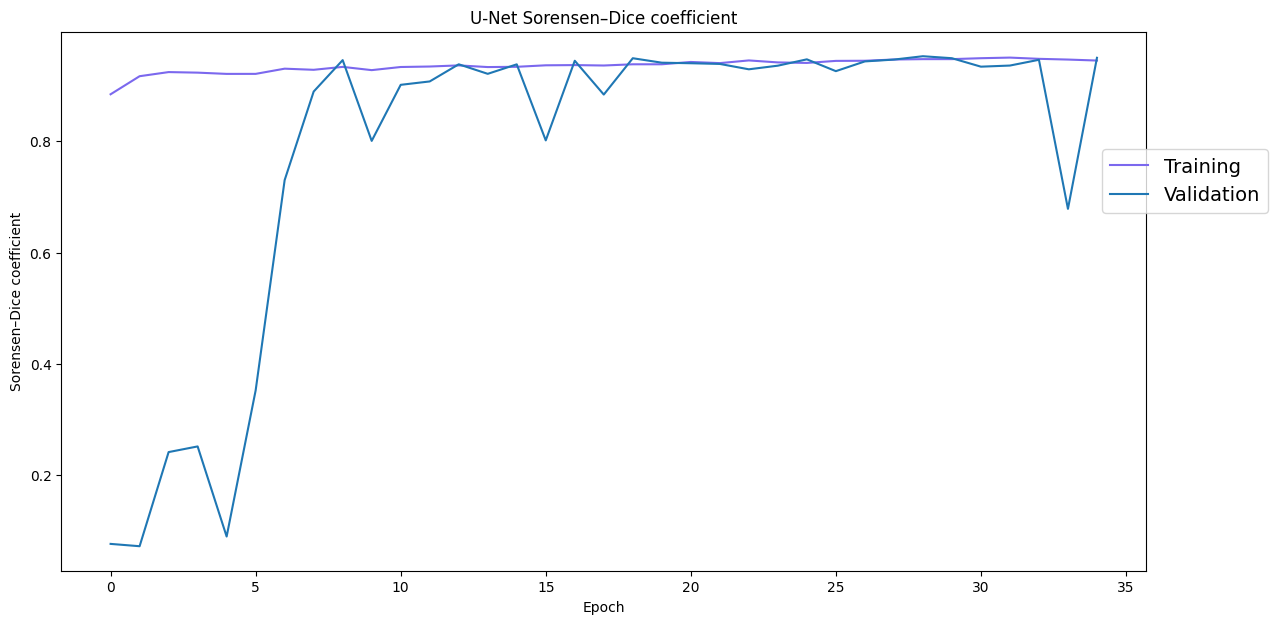

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['dice_coef'], label = 'Training',color = 'mediumslateblue')
plt.plot(history.history['val_dice_coef'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Sorensen–Dice coefficient')
plt.legend(bbox_to_anchor=(0.95,0.8), fontsize=14)
plt.title('U-Net Sorensen–Dice coefficient')
#plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()

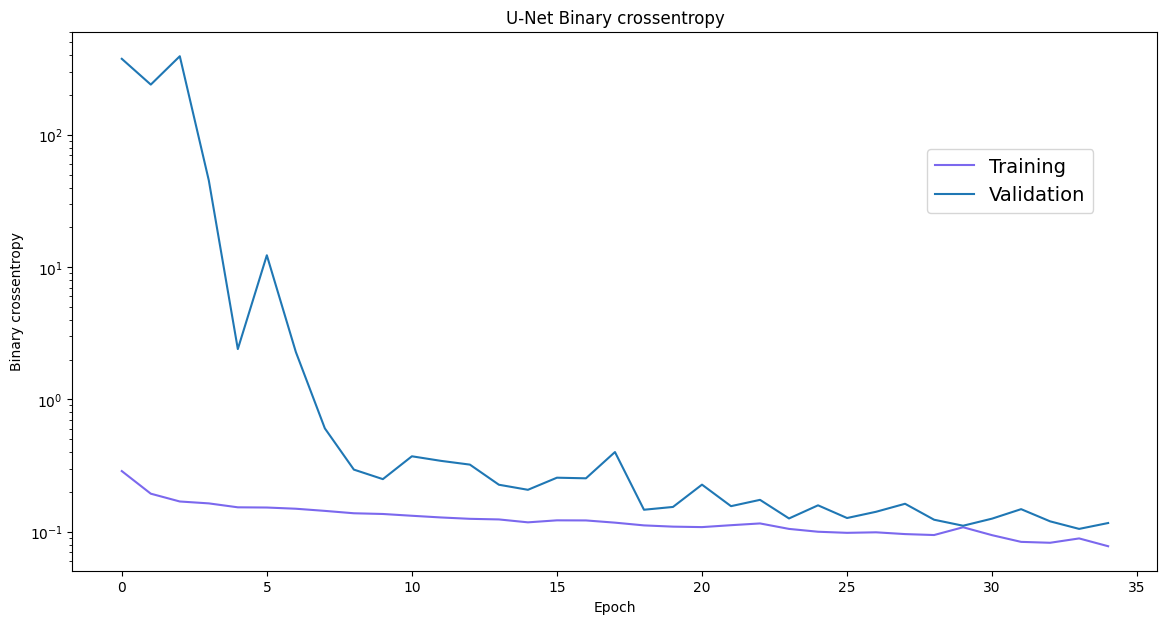

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label = 'Training', color = 'mediumslateblue')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Binary crossentropy')
plt.yscale('log')
plt.legend(bbox_to_anchor=(0.95,0.8),  fontsize=14)
plt.title('U-Net Binary crossentropy')
#plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()


In [ ]:
def index2color(index2):
    index = np.argmax(index2)
    color=[]
    if index == 0:
        color = [0, 0, 0]  # фон
    elif index == 1:
        color = [255, 0, 0]  # самолет
    return color 

In [ ]:
model.save_weights('/content/drive/My Drive/My Drive/model')

In [ ]:
model = unet(2, (img_width, img_height,3))
model.load_weights('/content/drive/My Drive/My Drive/model')

1/1 [==============================] - 0s 24ms/step


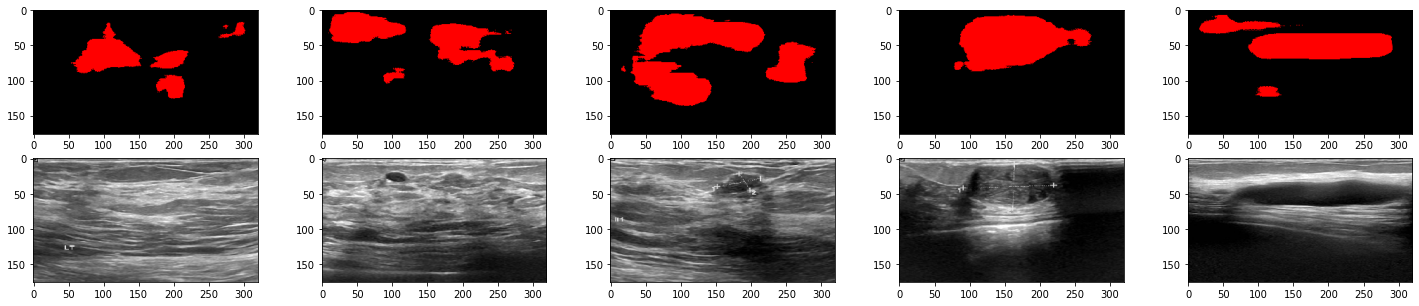

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
  predict = np.array(model.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
  pr = predict[0] # Берем нулевой элемент из перидкта
  pr1 = [] # Пустой лист под сегментированную картинку из predicta
  pr = pr.reshape(-1, n_classes) # Решейпим предикт
  for k in range(len(pr)): # Проходим по всем уровням (количество классов)
    pr1.append(index2color(pr[k])) # Переводим индекс в писксель
  pr1 = np.array(pr1) # Преобразуем в numpy
  pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
  img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
  axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
plt.show() 

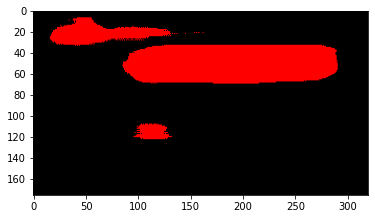

In [ ]:
seg = Image.fromarray(pr1.astype('uint8')).convert('RGBA')
plt.imshow(seg)

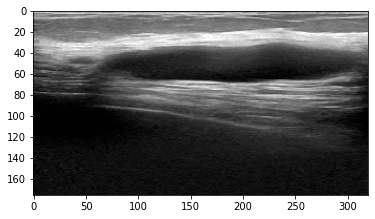

In [ ]:
plt.imshow(Image.fromarray(x_val[idx].astype('uint8')))

In [ ]:
mask = np.array(seg)
mask[mask[:,:,0] <= 10] = [0, 0, 0, 0]
mask[mask[:,:,0] > 10] = [0, 150, 0, 150]

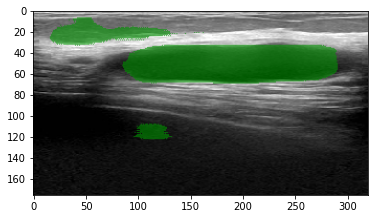

In [ ]:
img2 = Image.fromarray(x_val[idx].astype('uint8'))
img = Image.fromarray(mask).convert('RGBA')
img2.paste(img, (0, 0),img)
plt.imshow(img2)

Расширенная U-NET


In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unetWithMask(num_classes = 6, input_shape= (352, 480, 3)):
    img_input = Input(input_shape)                                      # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)      # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_1_out
    
    block_1_out_mask = Conv2D(64, (1, 1), padding='same')(block_1_out)  # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_1_out_mask

    x = MaxPooling2D()(block_1_out) # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)     # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_2_out

    block_2_out_mask = Conv2D(128, (1, 1), padding='same')(block_2_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_2_out_mask
    
    x = MaxPooling2D()(block_2_out)                                     # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_3_out

    block_3_out_mask = Conv2D(256, (1, 1), padding='same')(block_3_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_3_out_mask
        
    x = MaxPooling2D()(block_3_out)                                     # Добавляем слой MaxPooling2D

     # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)     # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                 # Добавляем слой Activation и запоминаем в переменной block_4_out

    block_4_out_mask = Conv2D(512, (1, 1), padding='same')(block_4_out) # Добавляем Conv2D-маску к текущему слою и запоминаем в переменную block_4_out_mask
            
    x = MaxPooling2D()(block_4_out)                                     # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)     # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation
    
    for_pretrained_weight = MaxPooling2D()(x)                           # Добавляем слой MaxPooling2D
 
    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_4_out, block_4_out_mask])                 # Объединем текущий слой со слоем block_4_out и слоем-маской block_4_out_mask
    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_3_out, block_3_out_mask])                 # Объединем текущий слой со слоем block_3_out и слоем-маской block_3_out_mask
    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = concatenate([x, block_2_out, block_2_out_mask])                 # Объединем текущий слой со слоем block_2_out и слоем-маской block_2_out_mask
    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                         # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                           # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = concatenate([x, block_1_out, block_1_out_mask])                # Объединем текущий слой со слоем block_1_out и слоем-маской block_1_out_mask
    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                          # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                        # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                          # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                        # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    
    return model                                                       # Возвращаем сформированную модель

In [ ]:
modelM3 = unetWithMask(num_classes, (img_width, img_height,3))
history = modelM3.fit(xTrain, yTrain, epochs=35, batch_size=16, validation_data = (x_val, y_val)) #  Обучаем модель на выборке по трем классам на полноразмерных изображениях

Epoch 1/35
27/27 [==============================] - 69s 1s/step - loss: 0.3058 - dice_coef: 0.8701 - val_loss: 9072.8779 - val_dice_coef: 0.0842
Epoch 2/35
27/27 [==============================] - 24s 903ms/step - loss: 0.1735 - dice_coef: 0.9441 - val_loss: 1141.3215 - val_dice_coef: 0.0896
Epoch 3/35
27/27 [==============================] - 25s 909ms/step - loss: 0.1618 - dice_coef: 0.9447 - val_loss: 32.3084 - val_dice_coef: 0.1151
Epoch 4/35
27/27 [==============================] - 25s 928ms/step - loss: 0.1596 - dice_coef: 0.9459 - val_loss: 306.0294 - val_dice_coef: 0.0773
Epoch 5/35
27/27 [==============================] - 25s 924ms/step - loss: 0.1446 - dice_coef: 0.9505 - val_loss: 24.3954 - val_dice_coef: 0.1370
Epoch 6/35
27/27 [==============================] - 24s 906ms/step - loss: 0.1350 - dice_coef: 0.9537 - val_loss: 10.9052 - val_dice_coef: 0.2427
Epoch 7/35
27/27 [==============================] - 24s 906ms/step - loss: 0.1408 - dice_coef: 0.9510 - val_loss: 1.7180 -

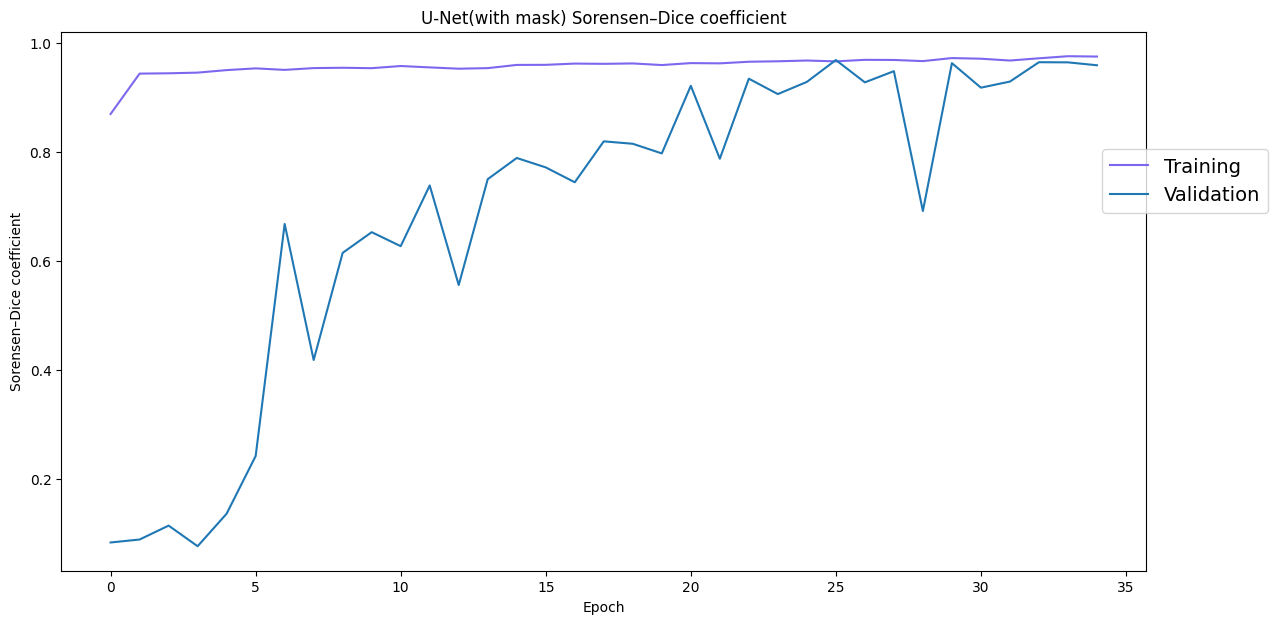

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['dice_coef'], label = 'Training',color = 'mediumslateblue')
plt.plot(history.history['val_dice_coef'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Sorensen–Dice coefficient')
plt.legend(bbox_to_anchor=(0.95,0.8), fontsize=14)
plt.title('U-Net(with mask) Sorensen–Dice coefficient')
#plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()

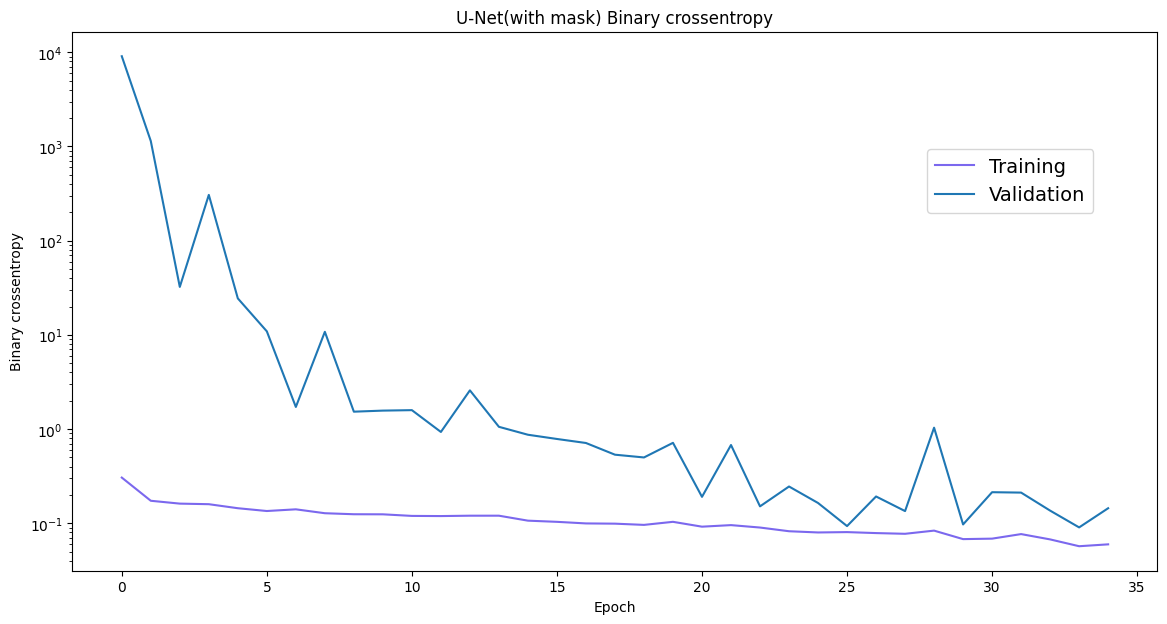

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label = 'Training', color = 'mediumslateblue')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Binary crossentropy')
plt.yscale('log')
plt.legend(bbox_to_anchor=(0.95,0.8),  fontsize=14)
plt.title('U-Net(with mask) Binary crossentropy')
#plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
modelM3.save_weights('/content/drive/My Drive/My Drive/modelM3')

In [ ]:
modelM3 = unetWithMask(2, (img_width, img_height,3))
modelM3.load_weights('/content/drive/My Drive/My Drive/modelM3')

1/1 [==============================] - 0s 39ms/step


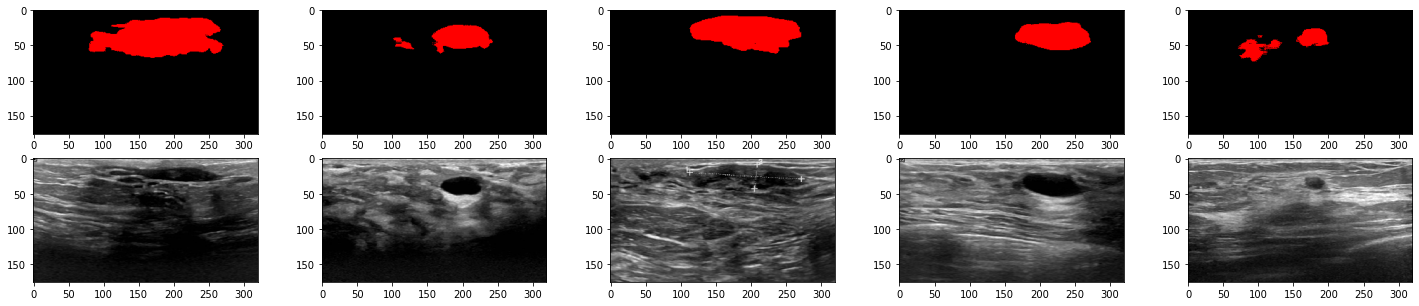

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # Получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) #Создаем полотно из n графиков
for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
  predict = np.array(modelM3.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
  pr = predict[0] # Берем нулевой элемент из перидкта
  pr1 = [] # Пустой лист под сегментированную картинку из predicta
  pr = pr.reshape(-1, n_classes) # Решейпим предикт
  for k in range(len(pr)): # Проходим по всем уровням (количество классов)
    pr1.append(index2color(pr[k])) # Переводим индекс в писксель
  pr1 = np.array(pr1) # Преобразуем в numpy
  pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
  img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
  axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
plt.show() 